In [2]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

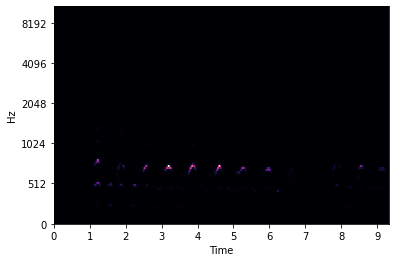

In [3]:
file_name = 'F01/Session1/wav_arrayMic/0001.wav'
y, sr = librosa.load(file_name)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [4]:
ps.shape

(128, 401)

In [5]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.05, time_masking_max_percentage=0.1):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

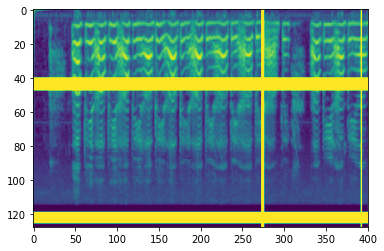

In [6]:
import matplotlib.pyplot as plt

p = librosa.power_to_db(ps, ref=np.max)
plt.figure()
plt.imshow(spec_augment(p),aspect= 'auto')
plt.show()

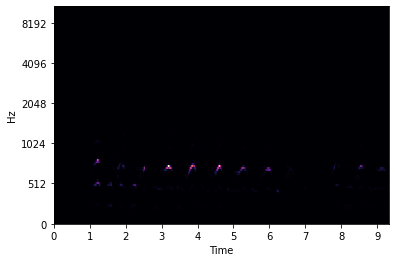

In [8]:
librosa.display.specshow(spec_augment(ps), y_axis='mel', x_axis='time')

In [10]:
ps.shape, spec_augment(ps).shape

((128, 401), (128, 401))

In [6]:
import numpy as np

arr = np.random.randint(0, 10, (7, 4))

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
import os
import numpy as np
from tqdm import tqdm

D = []
data = {
        "spect": [],
        "label": []
       }

directories =[  
                 ['F01','Atypical'],['F03','Atypical'],['F04','Atypical'],['FC01','Typical'],['FC02','Typical'],
                 ['FC03','Typical'],['M01','Atypical'],['M02','Atypical'],['M03','Atypical'],['M04','Atypical'],
                 ['M05','Atypical'],['MC01','Typical'],['MC02','Typical'],['MC03','Typical'],['MC04','Typical']
             ]

for pair in directories:
    directory = pair[0]
    label = pair[1]
    print(directory)
    for filename in os.listdir(directory):
        if filename != 'Notes':
            file = os.path.join(directory, filename)
            file = os.path.join(file, 'wav_arrayMic')
            if os.path.isdir(file):
                for audiofile in tqdm(os.listdir(file)):
                    f = os.path.join(file, audiofile)
                    if os.path.isfile(f):
                        if librosa.get_duration(filename=f) != 0:
                            y, sr = librosa.load(f)
                            
                            ps = librosa.feature.melspectrogram(y=y, sr=sr)
                            ps = spec_augment(ps)
                            if ps.shape[1] > 400 : continue
                            PS = ps
                            data["spect"].append(PS.tolist())
                            data["label"].append(label)
                            D.append( (np.array(padding(ps,128,400)), label) )

  1%|▌                                                                                 | 1/134 [00:00<00:26,  4.95it/s]

F01


  0%|                                                                                          | 0/204 [00:00<?, ?it/s]

F03


  1%|▍                                                                                 | 1/199 [00:00<00:32,  6.08it/s]

F04


  0%|▎                                                                                 | 1/256 [00:00<00:49,  5.14it/s]

FC01


  0%|                                                                                          | 0/269 [00:00<?, ?it/s]

FC02


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

FC03


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

M01


  0%|                                                                                          | 0/240 [00:00<?, ?it/s]

M02


  0%|                                                                                          | 0/416 [00:00<?, ?it/s]

M03


  0%|                                                                                          | 0/126 [00:00<?, ?it/s]

M04


  1%|▋                                                                                 | 1/128 [00:00<00:19,  6.62it/s]

M05


  0%|▏                                                                                 | 1/329 [00:00<00:35,  9.26it/s]

MC01


  0%|                                                                                          | 0/388 [00:00<?, ?it/s]

MC02


  0%|▏                                                                                 | 1/600 [00:00<01:14,  8.02it/s]

MC03


  0%|▏                                                                                 | 1/648 [00:00<01:23,  7.71it/s]

MC04


100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:22<00:00, 16.30it/s]


In [13]:
len(D)

9238

In [14]:
dataset = D
random.shuffle(dataset)

train = dataset[:8000]
dataset = dataset[8000:]
validate = dataset[:1000]
test = dataset[1000:]

X_train, y_train = zip(*train)
X_validate, y_validate = zip(*validate)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 400, 1) ) for x in X_train])
X_validate = np.array([x.reshape( (128, 400, 1) ) for x in X_validate])
X_test = np.array([x.reshape( (128, 400, 1) ) for x in X_test])

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
#y=to_categorical(labelencoder.fit_transform(y))
#y
y_train = np.array(to_categorical(labelencoder.fit_transform(y_train)))
y_validate = np.array(to_categorical(labelencoder.fit_transform(y_validate)))
y_test = np.array(to_categorical(labelencoder.fit_transform(y_test)))

In [16]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((8000, 128, 400, 1),
 (1000, 128, 400, 1),
 (238, 128, 400, 1),
 (8000, 2),
 (1000, 2),
 (238, 2))

In [17]:
model = Sequential()
input_shape=(128, 400, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 396, 24)      624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 198, 24)       0         
_________________________________________________________________
activation (Activation)      (None, 31, 198, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 194, 48)       28848     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 97, 48)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 6, 97, 48)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 93, 48)         5

In [18]:
import json
with open('spec_agument.json', "w") as fp:json.dump(data, fp, indent=1)

In [19]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

history = model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_validate, y_validate))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
63/63 [==============================] - 265s 4s/step - loss: 0.6756 - accuracy: 0.7629 - val_loss: 0.4345 - val_accuracy: 0.8290
Epoch 2/12
63/63 [==============================] - 243s 4s/step - loss: 0.4268 - accuracy: 0.8249 - val_loss: 0.3884 - val_accuracy: 0.8410
Epoch 3/12
63/63 [==============================] - 242s 4s/step - loss: 0.4036 - accuracy: 0.8367 - val_loss: 0.3759 - val_accuracy: 0.8560
Epoch 4/12
63/63 [==============================] - 236s 4s/step - loss: 0.3913 - accuracy: 0.8411 - val_loss: 0.3643 - val_accuracy: 0.8700
Epoch 5/12
63/63 [==============================] - 235s 4s/step - loss: 0.3707 - accuracy: 0.8536 - val_loss: 0.3543 - val_accuracy: 0.8610
Epoch 6/12
63/63 [==============================] - 235s 4s/step - loss: 0.3723 - accuracy: 0.8528 - val_loss: 0.3373 - val_accuracy: 0.8790
Epoch 7/12
63/63 [==============================] - 232s 4s/step - loss: 0.3483 - accuracy: 0.8648 - val_loss: 0.3263 - val_accuracy: 0.8730
Epoch 8/12
63

In [20]:
# save the model to disk
model.save('spec_aug')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: spec_aug\assets


In [15]:
reconstructed_model = keras.models.load_model("spec_aug")

In [22]:
predict = reconstructed_model.predict_classes(X_test)
prediction_class = labelencoder.inverse_transform(predict)
x, y = zip(*test)
y
match = 0
print('  Real       Prediction       Match')
for i in range(0,X_test.shape[0]):
    if(y[i]==prediction_class[i]):
        match+=1
    print(y[i] + '       ' + prediction_class[i] + '       ' + str(y[i]==prediction_class[i]))
print('Matched = ', match)
print('Not Matched = ',(X_test.shape[0] - match))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  Real       Prediction       Match
Typical       Typical       True
Atypical       Typical       False
Typical       Typical       True
Typical       Typical       True
Typical       Typical       True
Typical       Typical       True
Atypical       Atypical       True
Typical       Typical       True
Atypical       Typical       False
Typical       Typical       True
Typical       Typical       True
Typical       Typical       True
Atypical       Atypical       True
Typical       Typical       True
Typical       Typical       True
Typical       Typical       True
Typical       Typical       True
Typical       Typical       True
Typical       Typical       

In [4]:
import json
with open('spec_agument.json', "r") as f:
    data1 = json.load(f)
    
x1 = data1['spect']
y1 = data1['label']

In [7]:
D = []
for ps,label in zip(x1,y1):
    D.append( (np.array(padding(np.array(ps),128,400)), label) )

In [8]:
dataset = D
random.shuffle(dataset)

#train = dataset[:44000]
#dataset = dataset[44000:]
#validate = dataset[:1900]
test = dataset

#X_train, y_train = zip(*train)
#X_validate, y_validate = zip(*validate)
X_test, y_test = zip(*test)

# Reshape for CNN input
#X_train = np.array([x.reshape( (128, 400, 1) ) for x in X_train])
#X_validate = np.array([x.reshape( (128, 400, 1) ) for x in X_validate])
X_test = np.array([x.reshape( (128, 400, 1) ) for x in X_test])

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
#y=to_categorical(labelencoder.fit_transform(y))
#y
#y_train = np.array(to_categorical(labelencoder.fit_transform(y_train)))
#y_validate = np.array(to_categorical(labelencoder.fit_transform(y_validate)))
y_test = np.array(to_categorical(labelencoder.fit_transform(y_test)))

In [10]:
X_test.shape, y_test.shape

((9238, 128, 400, 1), (9238, 2))